In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
train_x = torch.linspace(0, 2, 50)
train_y = torch.sign(torch.cos(train_x * (4 * math.pi))).add(1).div(2)

In [3]:
train_x.shape

torch.Size([50])

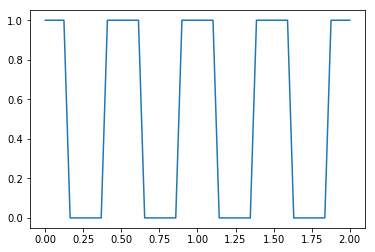

In [4]:
plt.plot(train_x.numpy(), train_y.numpy())

In [5]:
from gpytorch.models import AbstractVariationalGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy

class GPClassificationModel(AbstractVariationalGP):
    def __init__(self, train_x):
        variational_distribution = CholeskyVariationalDistribution(train_x.size(0))
        variational_strategy = VariationalStrategy(self, train_x, variational_distribution)
        super(GPClassificationModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        #self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.CosineKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        latent_pred = gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        return latent_pred

In [12]:
# Initialize model and likelihood
model = GPClassificationModel(train_x)
likelihood = gpytorch.likelihoods.BernoulliLikelihood()

In [14]:
from gpytorch.mlls.variational_elbo import VariationalELBO

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# "Loss" for GPs - the marginal log likelihood
# num_data refers to the amount of training data
mll = VariationalELBO(likelihood, model, train_y.numel())

training_iter =5000
for i in range(training_iter):
    # Zero backpropped gradients from previous iteration
    optimizer.zero_grad()
    # Get predictive output
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    if i%200==0:
        print('Iter %d/%d - Loss: %.3f' % (i, training_iter, loss.item()))
    optimizer.step()

Iter 0/5000 - Loss: 0.735
Iter 200/5000 - Loss: 0.734
Iter 400/5000 - Loss: 0.733
Iter 600/5000 - Loss: 0.732
Iter 800/5000 - Loss: 0.732
Iter 1000/5000 - Loss: 0.731
Iter 1200/5000 - Loss: 0.731
Iter 1400/5000 - Loss: 0.730
Iter 1600/5000 - Loss: 0.730
Iter 1800/5000 - Loss: 0.729
Iter 2000/5000 - Loss: 0.729
Iter 2200/5000 - Loss: 0.728
Iter 2400/5000 - Loss: 0.728
Iter 2600/5000 - Loss: 0.728
Iter 2800/5000 - Loss: 0.727
Iter 3000/5000 - Loss: 0.727
Iter 3200/5000 - Loss: 0.727
Iter 3400/5000 - Loss: 0.726
Iter 3600/5000 - Loss: 0.726
Iter 3800/5000 - Loss: 0.725
Iter 4000/5000 - Loss: 0.725
Iter 4200/5000 - Loss: 0.725
Iter 4400/5000 - Loss: 0.724
Iter 4600/5000 - Loss: 0.724
Iter 4800/5000 - Loss: 0.724


In [15]:
model(train_x)

MultivariateNormal(loc: torch.Size([50]))

In [16]:
train_y

tensor([1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0.,
        0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1.,
        1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.])

In [17]:
-mll(output, train_y)

tensor(0.7235, grad_fn=<NegBackward>)

In [18]:
train_y

tensor([1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0.,
        0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1.,
        1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.])

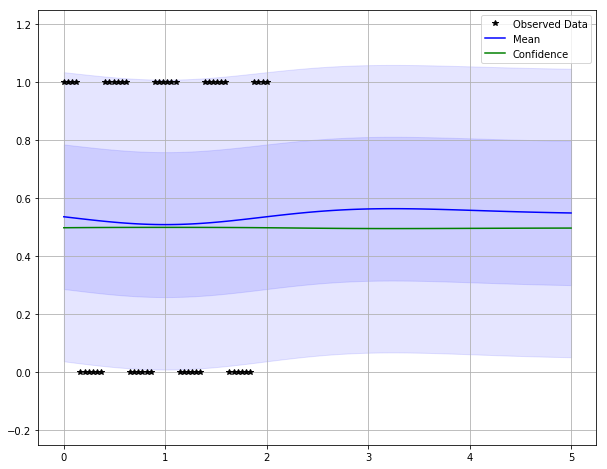

In [19]:
# Go into eval mode
model.eval()
likelihood.eval()
n_std = 2 # number of standard deviations to plot

with torch.no_grad():
    # Test x are regularly spaced by 0.01 0,1 inclusive
    test_x = torch.linspace(0, 5, 101)
    
    # Get classification predictions
    observed_pred = likelihood(model(test_x))
    #observed_pred = model(test_x)
    #pred_labels = observed_pred.mean.ge(0.5).float()
    pred_labels = observed_pred.mean.detach().numpy()
    std = observed_pred.stddev.detach().numpy()
    
    # Initialize fig and axes for plot
    f, ax = plt.subplots(1, 1, figsize=(10, 8))
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    ax.plot(test_x.numpy(), pred_labels, 'b')
    ax.plot(test_x.numpy(), std, 'g')
    ax.set_ylim([-0.25, 1.25])
    plt.grid()
    for i in range(n_std):
        plt.fill_between( test_x.numpy(),
            pred_labels - std * ((i+1.)/2.),
            pred_labels + std * ((i+1.)/2.),
            color="b",
            alpha=0.1)
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

In [20]:
dir(observed_pred)

['__abstractmethods__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_cache',
 '_abc_negative_cache',
 '_abc_negative_cache_version',
 '_abc_registry',
 '_batch_shape',
 '_event_shape',
 '_extended_shape',
 '_get_checked_instance',
 '_log_normalizer',
 '_mean_carrier_measure',
 '_natural_params',
 '_new',
 '_param',
 '_validate_args',
 '_validate_sample',
 'arg_constraints',
 'batch_shape',
 'cdf',
 'entropy',
 'enumerate_support',
 'event_dim',
 'event_shape',
 'expand',
 'expand_by',
 'has_enumerate_support',
 'has_rsample',
 'icdf',
 'independent',
 'log_prob',
 'logits',
 'mask',
 'mean',
 'param_shape',
 'perplexity',
 'probs',
 'reshape',
 'r

In [21]:
x1 = torch.linspace(0, 5, 101)

In [22]:
observed_pred.cdf(x1)

NotImplementedError: 

## References:
- https://gpytorch.readthedocs.io/en/latest/examples/02_Simple_GP_Classification/Simple_GP_Classification.html